### 데이터 불러오기

In [108]:
import pandas as pd
import numpy as np
import math
import seaborn as sns
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeRegressor

import pandas as pd
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

In [109]:
# train, test 데이터를 불러옵니다.
path = '/Users/yniyunj/Desktop/AI/250115-EVpriceprediction'
train = pd.read_csv(path + '/open/train.csv')
test = pd.read_csv(path + '/open/test.csv')

In [110]:
import matplotlib.pyplot as plt
from matplotlib import rcParams, font_manager

# 한글 폰트 파일 경로 지정
font_path = "/Users/yniyunj/Library/Fonts/NanumGothic-Regular.ttf"  # 설치된 폰트 경로
font_prop = font_manager.FontProperties(fname=font_path)

# Matplotlib 설정
rcParams['font.family'] = font_prop.get_name()
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 깨짐 방지

print("현재 설정된 폰트:", plt.rcParams['font.family'])

현재 설정된 폰트: ['NanumGothic']


In [111]:
train

,ID,제조사,모델,차량상태,배터리용량,구동방식,주행거리(km),보증기간(년),사고이력,연식(년),가격(백만원)
0,TRAIN_0000,P사,TayGTS,Nearly New,86.077,AWD,13642,0,No,2,159.66
1,TRAIN_0001,K사,Niro,Nearly New,56.000,FWD,10199,6,No,0,28.01
2,TRAIN_0002,A사,eT,Brand New,91.200,AWD,2361,7,No,0,66.27
3,TRAIN_0003,A사,RSeTGT,Nearly New,NaN,AWD,21683,3,No,0,99.16
4,TRAIN_0004,B사,i5,Pre-Owned,61.018,AWD,178205,1,No,0,62.02
...,...,...,...,...,...,...,...,...,...,...,...
7492,TRAIN_7492,H사,ION5,Brand New,NaN,AWD,3773,10,No,0,35.95
7493,TRAIN_7493,B사,i3,Pre-Owned,46.000,RWD,135411,2,No,0,23.40
7494,TRAIN_7494,P사,TayCT,Brand New,NaN,AWD,1363,2,No,0,120.00
7495,TRAIN_7495,B사,i3,Nearly New,56.000,RWD,39445,6,No,2,24.00


### 데이터 살펴보기

- 배터리용량 결측치가 2711개다.

In [112]:
# 각 열의 결측치가 아닌 값 개수와 결측치 개수 출력
non_missing_values_count = train.notnull().sum()

for column, count in non_missing_values_count.items():
    missing_count = len(train) - count  # 전체 개수에서 결측치가 아닌 값 개수 차감
    print(f"{column}: {count}, 결측치: {missing_count}개")

ID: 7497, 결측치: 0개
제조사: 7497, 결측치: 0개
모델: 7497, 결측치: 0개
차량상태: 7497, 결측치: 0개
배터리용량: 4786, 결측치: 2711개
구동방식: 7497, 결측치: 0개
주행거리(km): 7497, 결측치: 0개
보증기간(년): 7497, 결측치: 0개
사고이력: 7497, 결측치: 0개
연식(년): 7497, 결측치: 0개
가격(백만원): 7497, 결측치: 0개


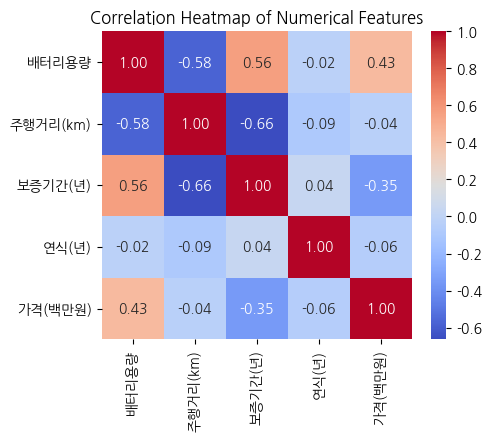

In [113]:
# 주요 숫자형 변수 선택
numerical_columns = ['배터리용량', '주행거리(km)', '보증기간(년)', '연식(년)', '가격(백만원)']
categorical_columns = ['제조사', '모델', '차량상태', '구동방식', '사고이력']

# 상관계수 행렬 계산
correlation_matrix = train[numerical_columns].corr()

# 히트맵 시각화
plt.figure(figsize=(5, 4))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title("Correlation Heatmap of Numerical Features")
plt.show()

- 모델별 가격: 0.99
- 모델과 제조사: 0.91
- 제조사와 가격: 0.90 

  제조사                     모델 목록  평균 가격(백만원)
0  P사      [TayGTS, TayCT, Tay]  131.990934
1  A사        [eT, RSeTGT, Q4eT]   75.128354
2  T사          [MS, MY, MX, M3]   70.153724
3  B사              [i5, iX, i3]   55.212344
4  V사                     [ID4]   38.411702
5  H사  [ION6, IONIQ, KNE, ION5]   31.312991
6  K사         [Niro, Soul, EV6]   30.779029


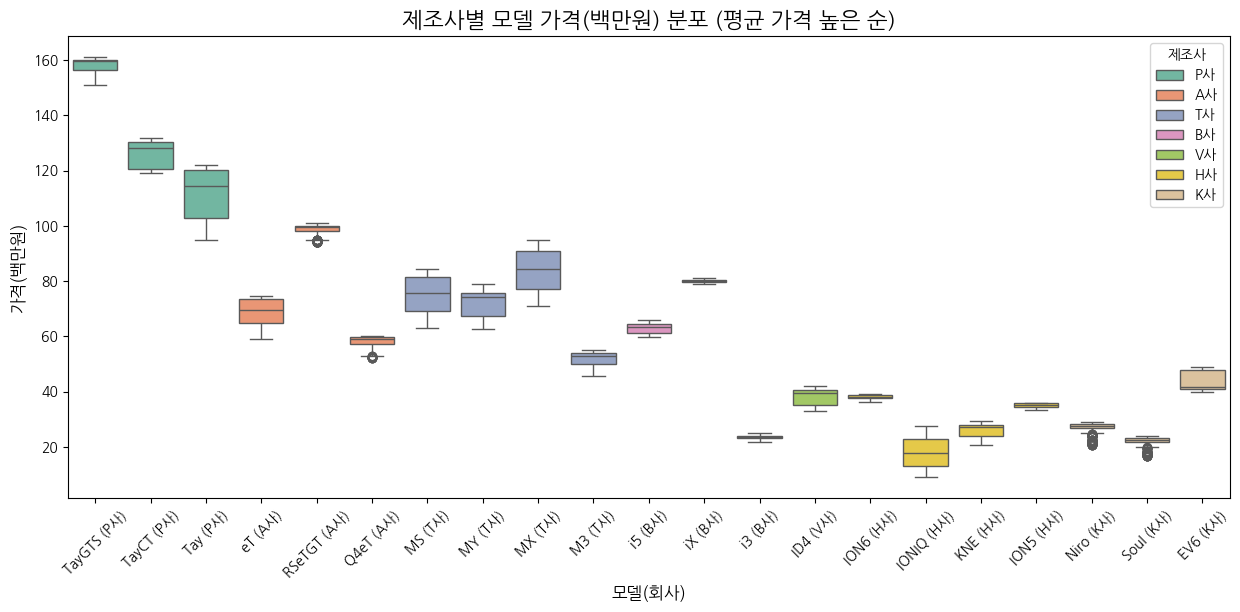

In [114]:
# 제조사별 고유 모델 추출 및 평균 가격 계산
manufacturer_models = train.groupby('제조사')['모델'].unique()
manufacturer_avg_price = train.groupby('제조사')['가격(백만원)'].mean()

# 두 데이터를 병합하여 하나의 데이터프레임으로 결합
manufacturer_summary = pd.DataFrame({'모델 목록': manufacturer_models, '평균 가격(백만원)': manufacturer_avg_price}).reset_index()

# 평균 가격을 기준으로 정렬
manufacturer_summary = manufacturer_summary.sort_values(by='평균 가격(백만원)', ascending=False).reset_index(drop=True)
print(manufacturer_summary)

# 회사별 순서를 평균 가격이 높은 순으로 정렬
manufacturer_order = manufacturer_summary['제조사'].tolist()

# 모델(회사) 형식으로 새로운 열 생성
train['모델(회사)'] = train['모델'] + " (" + train['제조사'] + ")"

# 모델(회사) 순서를 정렬
model_order = train.set_index('제조사').loc[manufacturer_order]['모델(회사)'].unique()

# 박스 플롯 생성
plt.figure(figsize=(15, 6))
sns.boxplot(x='모델(회사)', y='가격(백만원)', hue='제조사', data=train, order=model_order, hue_order=manufacturer_order, palette='Set2')

# 그래프 꾸미기
plt.title("제조사별 모델 가격(백만원) 분포 (평균 가격 높은 순)", fontsize=16)
plt.xticks(rotation=45, fontsize=10)
plt.xlabel("모델(회사)", fontsize=12)
plt.ylabel("가격(백만원)", fontsize=12)
plt.legend(title="제조사", loc="upper right", fontsize=10)

plt.show()


제조사: A사, 모델: ['eT', 'RSeTGT', 'Q4eT']
제조사: B사, 모델: ['i5', 'iX', 'i3']
제조사: H사, 모델: ['ION6', 'IONIQ', 'KNE', 'ION5']
제조사: K사, 모델: ['Niro', 'Soul', 'EV6']
제조사: P사, 모델: ['TayGTS', 'TayCT', 'Tay']
제조사: T사, 모델: ['MS', 'MY', 'MX', 'M3']
제조사: V사, 모델: ['ID4']


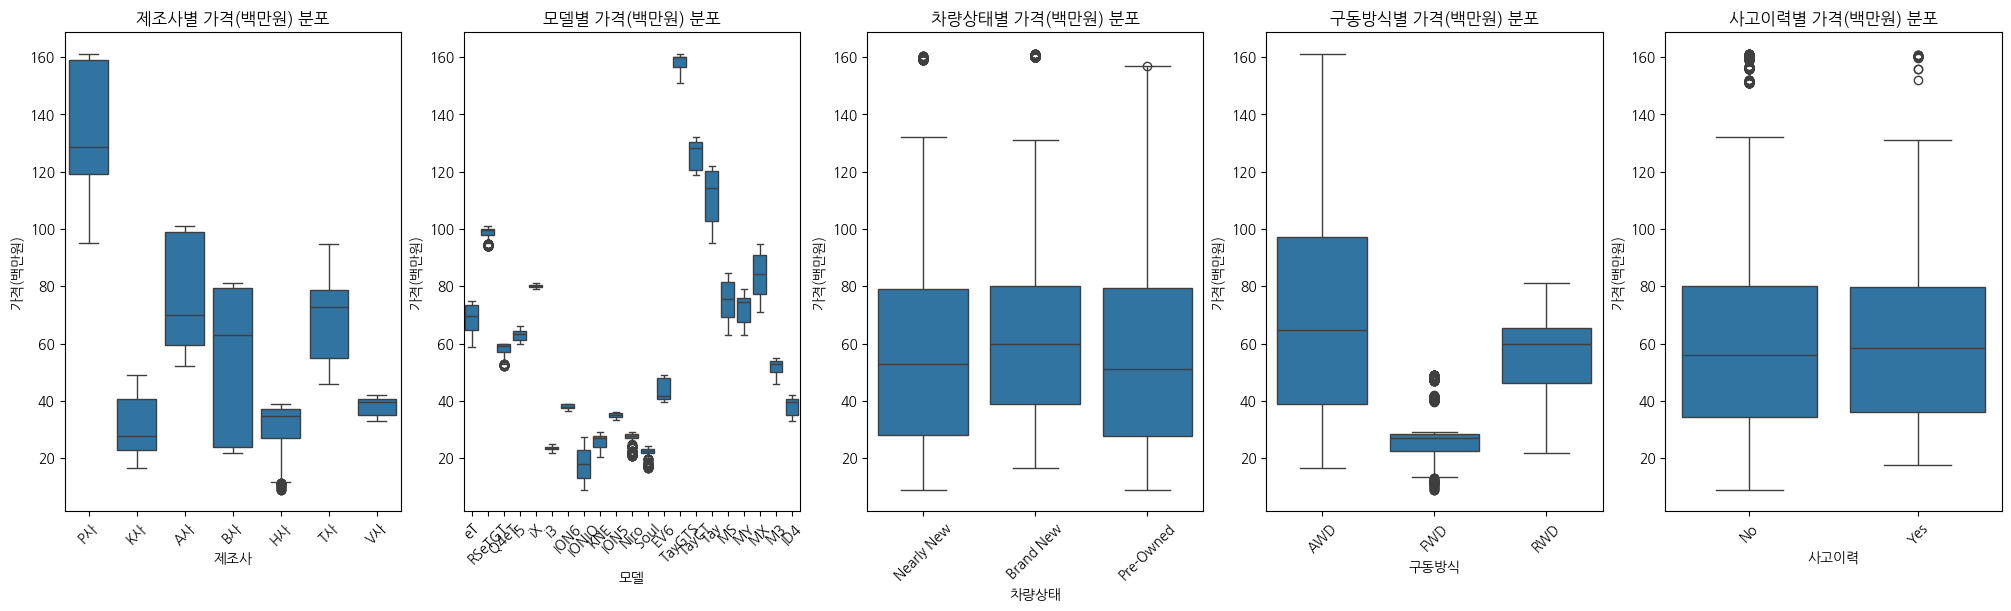

In [115]:
# 제조사별 고유 모델 추출
manufacturer_models = train.groupby('제조사')['모델'].unique()

# 데이터프레임으로 변환하여 보기 좋게 출력
manufacturer_models_df = manufacturer_models.reset_index()
manufacturer_models_df.columns = ['제조사', '모델 목록']

# 결과 확인
for index, row in manufacturer_models_df.iterrows():
    print(f"제조사: {row['제조사']}, 모델: {list(row['모델 목록'])}")

# 서브플롯 생성
fig, axes = plt.subplots(1, len(categorical_columns), figsize=(20, 6), constrained_layout=True)

for i, col in enumerate(categorical_columns):
    if col == '모델':
        # 모델 순서를 제조사별로 정렬
        model_order = train.groupby('제조사')['모델'].apply(list).explode().unique()
        sns.boxplot(x=col, y='가격(백만원)', data=train, ax=axes[i], order=model_order)
    else:
        sns.boxplot(x=col, y='가격(백만원)', data=train, ax=axes[i])
    axes[i].set_title(f"{col}별 가격(백만원) 분포")
    axes[i].tick_params(axis='x', rotation=45)

plt.show()


In [116]:
print(train['제조사'].unique())
print(train['모델'].unique())
print(train['차량상태'].unique())
print(train['구동방식'].unique())
print(train['사고이력'].unique())

['P사' 'K사' 'A사' 'B사' 'H사' 'T사' 'V사']
['TayGTS' 'Niro' 'eT' 'RSeTGT' 'i5' 'ION6' 'MS' 'MY' 'Q4eT' 'ID4' 'TayCT'
 'Soul' 'iX' 'MX' 'IONIQ' 'EV6' 'KNE' 'M3' 'i3' 'ION5' 'Tay']
['Nearly New' 'Brand New' 'Pre-Owned']
['AWD' 'FWD' 'RWD']
['No' 'Yes']


- 인코딩하기
    - 모델, 차량상태, 구동방식 (제조사 제거)
    - 제조사를 인코딩할 필요 없이, 모델만 인코딩해도 두 정보를 모두 포함한 것과 동일한 효과를 얻는다.
    - 모델은 제조사와 이미 1:1 또는 1:N 관계를 가지고, 특정 모델이 어떤 제조사에 속하는지 이미 알려주기 때문이다.


In [117]:
# 데이터 복사
encoded_train = train.copy()

# 원-핫 인코딩 대상 변수 (제조사 제외)
one_hot_features = ['모델', '차량상태', '구동방식']

# 원-핫 인코더 초기화
one_hot_encoder = OneHotEncoder(sparse_output=False, drop='first')  # drop='first'는 다중공선성 방지

# 원-핫 인코딩 적용
encoded_one_hot = pd.DataFrame(one_hot_encoder.fit_transform(encoded_train[one_hot_features]).astype(int),
                               columns=one_hot_encoder.get_feature_names_out(one_hot_features))

# 라벨 인코딩 대상 변수
label_encoder = LabelEncoder()

# '사고이력'에 라벨 인코딩 적용
encoded_train['사고이력'] = label_encoder.fit_transform(encoded_train['사고이력'])

# 원본 범주형 열 제거
encoded_train = encoded_train.drop(columns=one_hot_features)

# 인코딩된 열 병합
encoded_data = pd.concat([encoded_train, encoded_one_hot], axis=1)

# 결과 확인
print(encoded_data.head())

# CSV로 저장
encoded_data.to_csv(path + '/open/encoded_train.csv', index=False)

           ID 제조사   배터리용량  주행거리(km)  보증기간(년)  사고이력  연식(년)  가격(백만원)  \
0  TRAIN_0000  P사  86.077     13642        0     0      2   159.66   
1  TRAIN_0001  K사  56.000     10199        6     0      0    28.01   
2  TRAIN_0002  A사  91.200      2361        7     0      0    66.27   
3  TRAIN_0003  A사     NaN     21683        3     0      0    99.16   
4  TRAIN_0004  B사  61.018    178205        1     0      0    62.02   

        모델(회사)  모델_ID4  ...  모델_TayCT  모델_TayGTS  모델_eT  모델_i3  모델_i5  모델_iX  \
0  TayGTS (P사)       0  ...         0          1      0      0      0      0   
1    Niro (K사)       0  ...         0          0      0      0      0      0   
2      eT (A사)       0  ...         0          0      1      0      0      0   
3  RSeTGT (A사)       0  ...         0          0      0      0      0      0   
4      i5 (B사)       0  ...         0          0      0      0      1      0   

   차량상태_Nearly New  차량상태_Pre-Owned  구동방식_FWD  구동방식_RWD  
0                1               0       

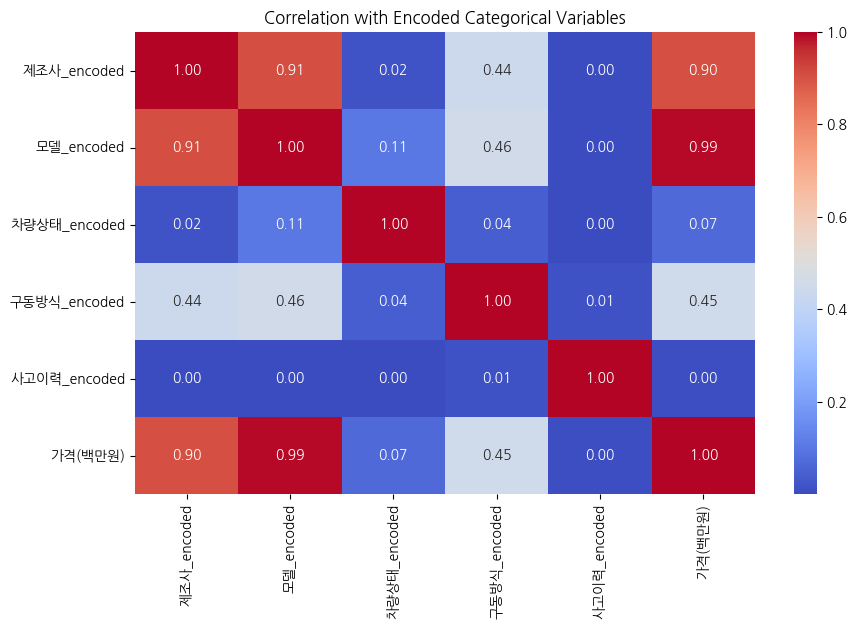

In [91]:
# 타겟 인코딩
for col in categorical_columns:
    mean_encoded = train.groupby(col)['가격(백만원)'].mean()
    train[f"{col}_encoded"] = train[col].map(mean_encoded)

# 타겟 인코딩된 변수와 숫자형 변수 간 상관관계 확인
encoded_columns = [f"{col}_encoded" for col in categorical_columns]
correlation_matrix = train[encoded_columns + ['가격(백만원)']].corr()

# 히트맵 시각화
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title("Correlation with Encoded Categorical Variables")
plt.show()

In [5]:
def plot_histogram(data, columns_to_plot, cols=2, figsize=(10, 5)):
    # 해당 열이 데이터 내 존재하는 지 확인합니다.
    valid_columns = [col for col in columns_to_plot if col in data.columns]
    if not valid_columns:
        raise ValueError("해당 열이 존재하지 않습니다.")
    
    # 서브플롯을 생성하기 위해 행과 열의 수를 확인합니다.
    num_vars = len(valid_columns)
    rows = math.ceil(num_vars / cols)
    
    # 서브플롯을 생성합니다.
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    axes = axes.flatten()  
    
    for i, col in enumerate(valid_columns):
        sns.histplot(x=data[col], ax=axes[i])
        axes[i].set_title(col)
    
    # 빈 서브플롯을 삭제합니다.
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()

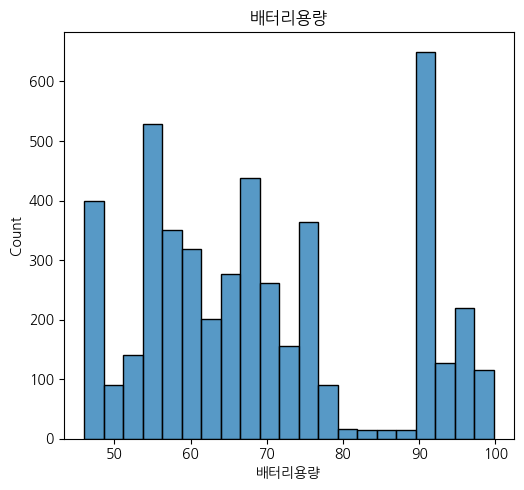

In [6]:
# 그래프를 생성할 열을 담은 리스트 입니다.
columns_to_plot = ['배터리용량']

# 선언한 함수를 사용하여 그래프를 생성합니다.
plot_histogram(data=train, columns_to_plot=columns_to_plot, cols=2, figsize=(10, 5))

In [7]:
def plot_categorical(data, columns_to_plot, cols=3, figsize=(10, 5)): 
    # 해당열이 데이터 내 존재하는지 확인합니다.
    valid_columns = [col for col in columns_to_plot if col in data.columns]
    if not valid_columns:
        raise ValueError("해당 열이 존재하지 않습니다.")
    
    # 서브플롯을 생성하기 위해 행과 열의 수를 확인합니다.
    num_vars = len(valid_columns)
    rows = math.ceil(num_vars / cols)
    
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    axes = axes.flatten()  
    
    for i, col in enumerate(valid_columns):
        sns.countplot(x=data[col], ax=axes[i], palette="viridis", hue=None, order=data[col].value_counts().index)
        axes[i].set_title(f'Distribution of {col}')
        axes[i].tick_params(axis='x', rotation=45)
    
    # 빈 서비플롯을 삭제합니다.
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()

/var/folders/2k/10fc4g4d33q5h9qc2fn4wk6m0000gn/T/ipykernel_85992/1592594574.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=data[col], ax=axes[i], palette="viridis", hue=None, order=data[col].value_counts().index)


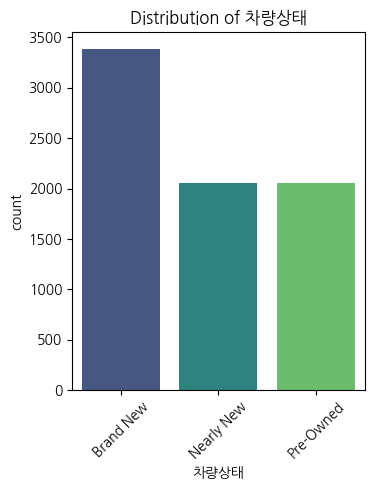

In [8]:
# 그래프를 생성할 열을 담은 리스트 입니다.
columns_to_plot = ['차량상태']

# 선언한 함수를 사용하여 그래프를 생성합니다.
plot_categorical(data=train, columns_to_plot=columns_to_plot)

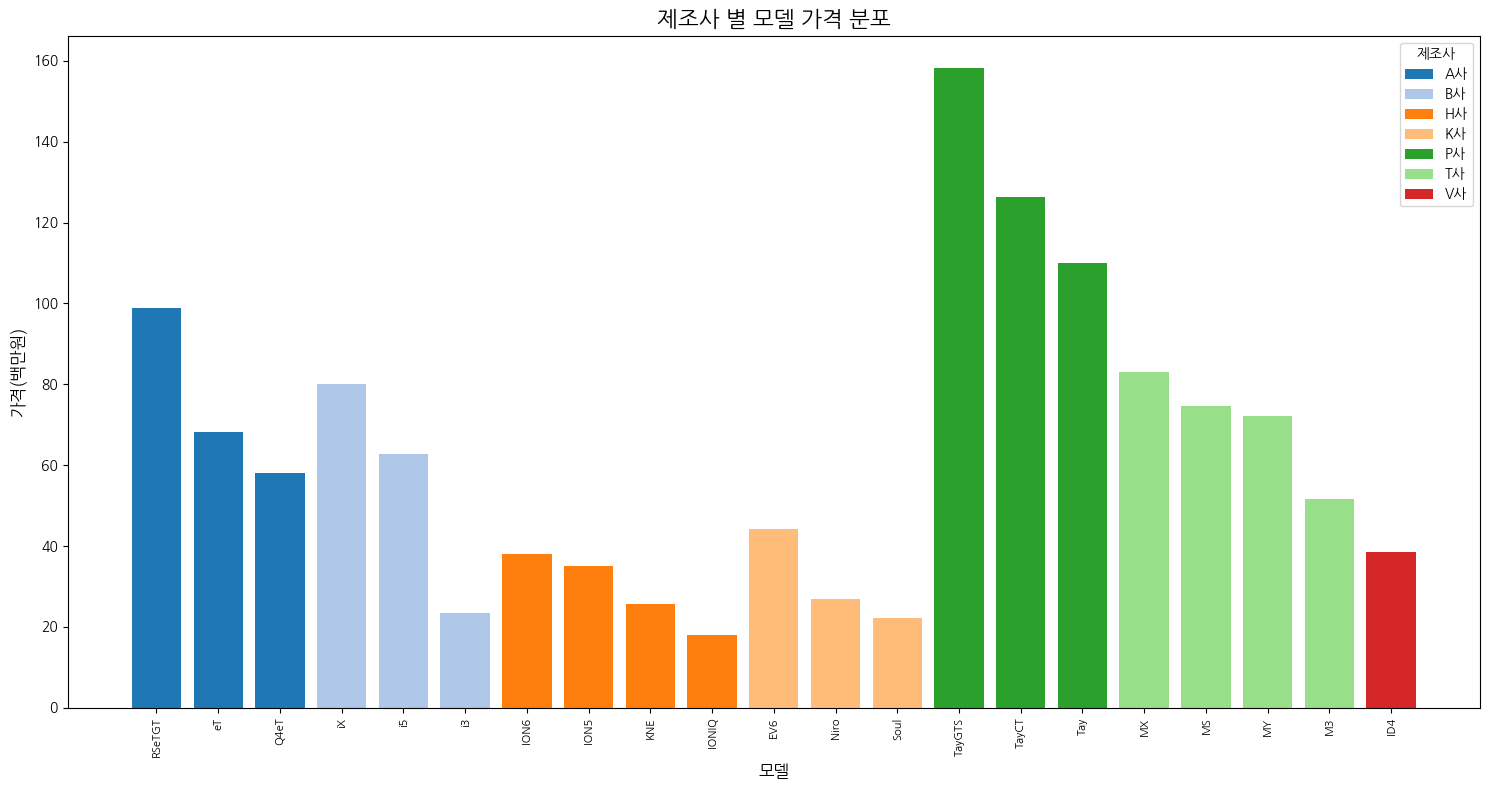

In [9]:
# 제조사의 모델별 가격의 평균으로 그룹화 합니다.
grouped_data = train.groupby(['제조사', '모델'])['가격(백만원)'].mean().reset_index()

# 더 나은 그래프를 그리기 위해 제조사별로 정렬합니다.
grouped_data = grouped_data.sort_values(by=['제조사', '가격(백만원)'], ascending=[True, False])

# 그래프 전체의 크기를 나타냅니다.
plt.figure(figsize=(15, 8))

# 유니크한 제조사 명을 정의합니다.
brands = grouped_data['제조사'].unique()
colors = plt.cm.tab20.colors[:len(brands)]

# 제조사별로 모델의 가격을 바 그래프 형태로 나타냅니다.
for i, brand in enumerate(brands):
    brand_data = grouped_data[grouped_data['제조사'] == brand]
    plt.bar(
        brand_data['모델'],
        brand_data['가격(백만원)'],
        label=brand,
        color=colors[i % len(colors)]
    )

# 그래프의 형태를 정의합니다.
plt.title('제조사 별 모델 가격 분포', fontsize=16)
plt.xlabel('모델', fontsize=12)
plt.ylabel('가격(백만원)', fontsize=12)
plt.xticks(rotation=90, fontsize=8)
plt.legend(title='제조사', fontsize=10, loc='upper right')
plt.tight_layout()
plt.show()

### 데이터 전처리

In [10]:
# 데이터 내 결측치를 확인합니다.
train.isna().sum()

ID             0
제조사            0
모델             0
차량상태           0
배터리용량       2711
구동방식           0
주행거리(km)       0
보증기간(년)        0
사고이력           0
연식(년)          0
가격(백만원)        0
dtype: int64

In [11]:
# 데이터 내 결측치를 train데이터의 평균값을 사용하여 대체합니다.
train['배터리용량'].fillna(train['배터리용량'].mean(),inplace=True)
test['배터리용량'].fillna(train['배터리용량'].mean(),inplace=True)

/var/folders/2k/10fc4g4d33q5h9qc2fn4wk6m0000gn/T/ipykernel_85992/2343584787.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train['배터리용량'].fillna(train['배터리용량'].mean(),inplace=True)
/var/folders/2k/10fc4g4d33q5h9qc2fn4wk6m0000gn/T/ipykernel_85992/2343584787.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting va

In [12]:
# 학습과 예측을 위해 데이터를 분리합니다.
x_train = train.drop(['ID', '가격(백만원)'], axis = 1)
y_train = train['가격(백만원)']

x_test = test.drop('ID', axis = 1)

In [13]:
# 범주형 변수에 대해 레이블 인코딩을 적용합니다.
categorical_features = [col for col in x_train.columns if x_train[col].dtype == 'object']

for i in categorical_features:
    le = LabelEncoder()
    le=le.fit(x_train[i]) 
    x_train[i]=le.transform(x_train[i])
    
    for case in np.unique(x_test[i]):
        if case not in le.classes_: 
            le.classes_ = np.append(le.classes_, case) 
    x_test[i]=le.transform(x_test[i])
    
display(x_train.head(3))

,제조사,모델,차량상태,배터리용량,구동방식,주행거리(km),보증기간(년),사고이력,연식(년)
0,4,16,1,86.077,0,13642,0,0,2
1,3,10,1,56.000,1,10199,6,0,0
2,0,17,0,91.200,0,2361,7,0,0


### 학습 및 예측하기

In [14]:
# 모델을 선언하고, 학습을 진행합니다.
model = DecisionTreeRegressor()
model.fit(x_train, y_train)

DecisionTreeRegressor()

In [15]:
# 예측을 수행합니다.
pred = model.predict(x_test)

### 제출하기

In [17]:
# sample_submission 파일을 불러옵니다.
submit = pd.read_csv(path+'/open/sample_submission.csv')

In [18]:
# 예측한 결과를 submit에 저장합니다.
submit['가격(백만원)'] = pred
submit.head()

,ID,가격(백만원)
0,TEST_000,130.84
1,TEST_001,79.26
2,TEST_002,64.70
3,TEST_003,34.21
4,TEST_004,47.80


In [19]:
# 제출을 위해 baseline_submission.csv란 이름으로 CSV 파일을 저장합니다.
submit.to_csv(path+'/submission/240115-pred01.csv',index=False)